In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt

In [7]:
# Wrapper for Butterworth filter
def filter(data, cutoff_freq, fs, btype='low',order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

Average RF period: 44.444444 +- 0.294811


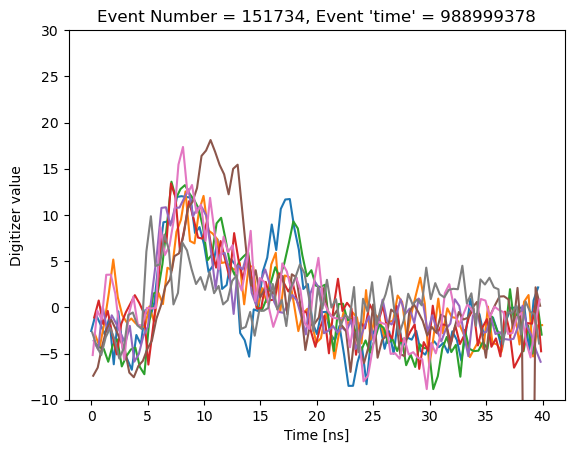

Average RF period: 44.400000 +- 0.000000


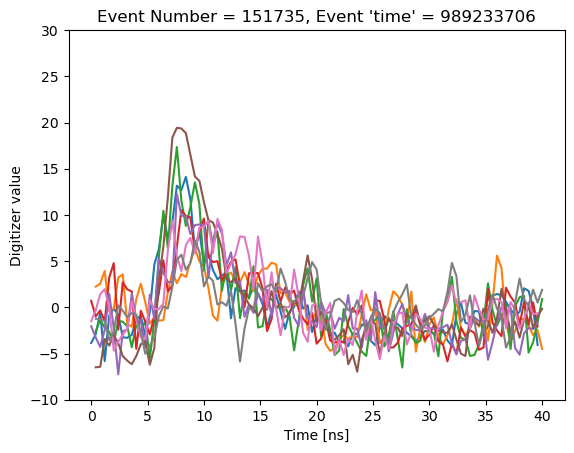

Average RF period: 44.450000 +- 0.132288


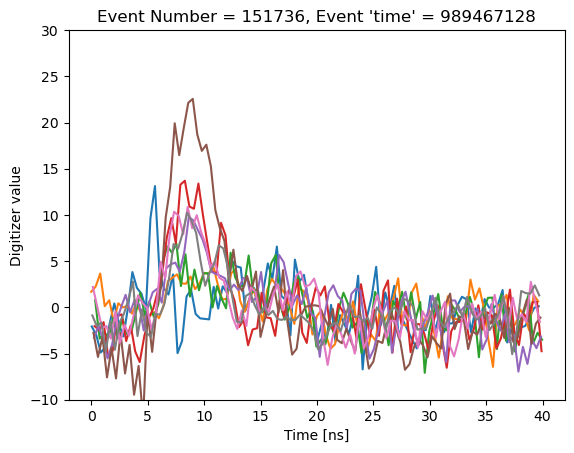

Average RF period: 44.488889 +- 0.166296


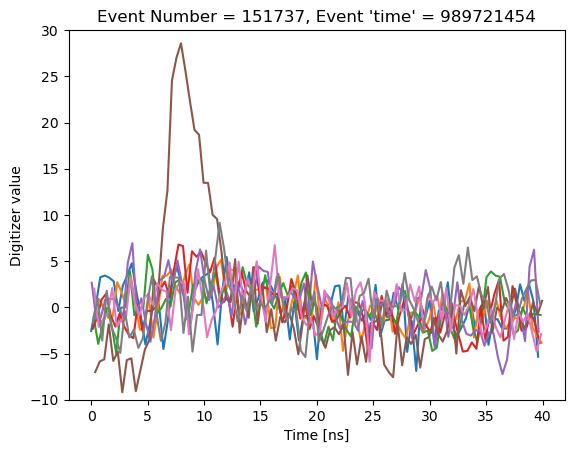

Average RF period: 44.444444 +- 0.125708


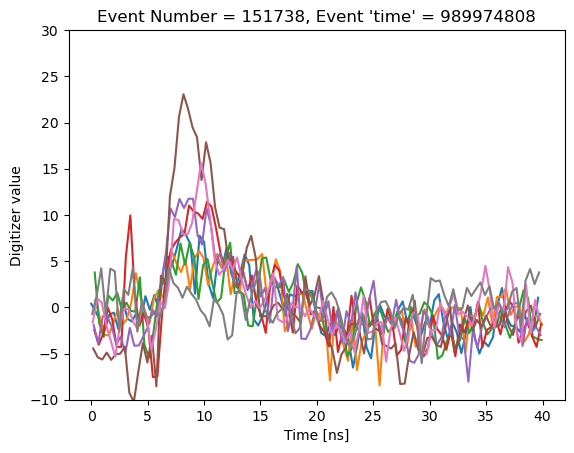

Average RF period: 44.450000 +- 0.132288


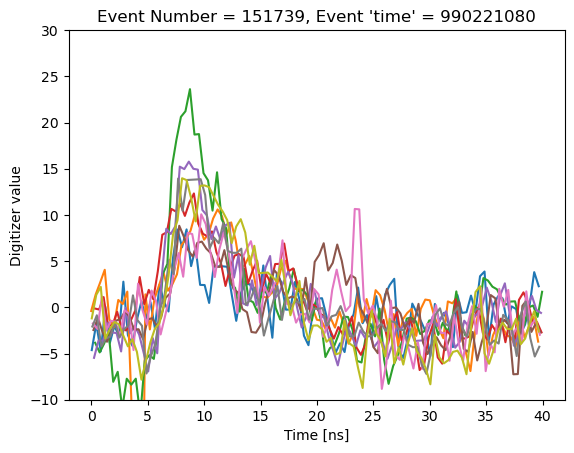

Average RF period: 44.444444 +- 0.125708


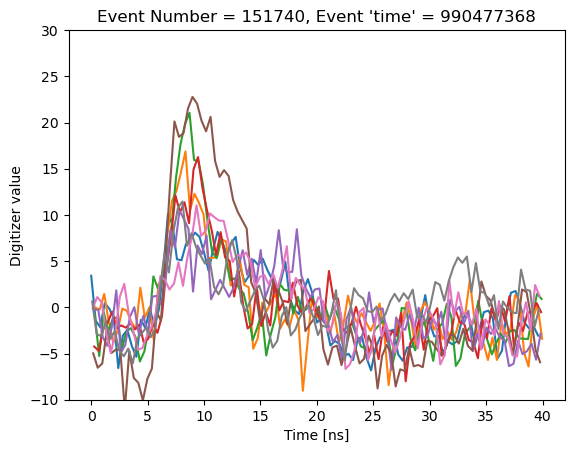

Average RF period: 44.450000 +- 0.239792


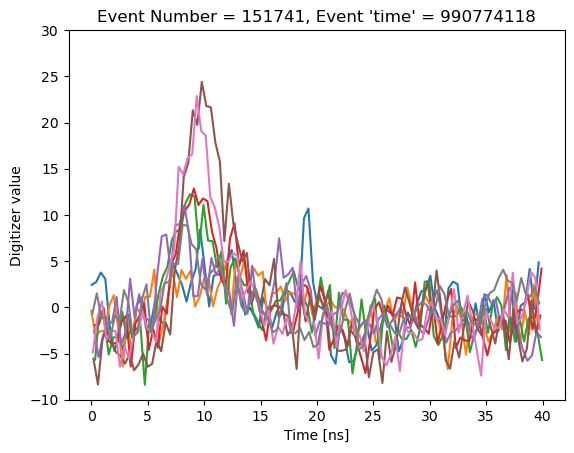

Average RF period: 44.400000 +- 0.200000


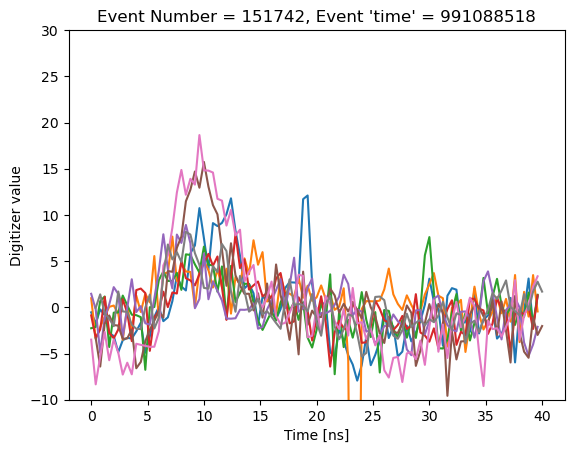

Average RF period: 44.444444 +- 0.125708


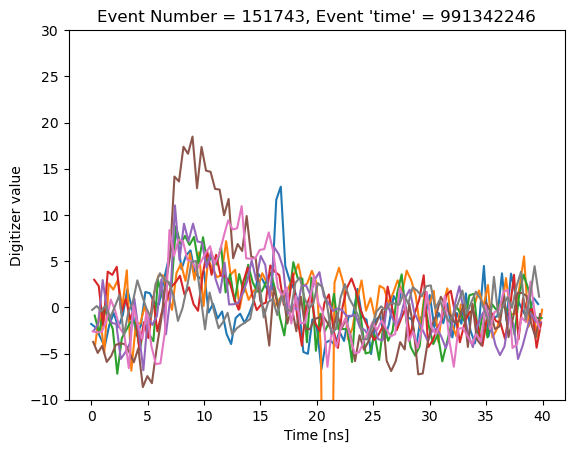

<Figure size 640x480 with 0 Axes>

In [75]:
target_dir = r"./"
target_file = r"WaveDump_Data_15_25_15_clipped.csv"

plot_data = True

def working_anim(index, refresh): #Just command line animation to see if code is hung or slowing
    if (index%400 == 0):
        print("Working  |", end = "\r")
    if (index%400 == int(refresh/4)):
        print("Working  /", end = "\r")
    if (index%400 == int(refresh/2)):
        print("Working  -", end = "\r")
    if (index%400 == int(refresh*3/4)):
        print("Working  \\", end = "\r")

def transform_data(raw_data): #chatGPT wrote this
    str_data = [string.split(',') for string in raw_data]
    unformatted_data = [[int(sublist[0]), float(sublist[1]), float(sublist[2])] for sublist in str_data]
    data = list(map(list, zip(*unformatted_data)))
    return data

def extract_data(file_in, plot_data,max_records=-1):  
    index = 0
    all_data = []
    with open(file_in, 'r') as file:                                #Open file     
        while True:                

############Get the trace from the file
            line = file.readline().strip()                          #Readline
            
            if not any(line):                                       #Check to see if input file line is empty (aka end of file)
                break       
                    
            if (line[:6] == "Record"):                              #Check for start of trace
                n_data = int(line.split(":")[1].strip())            #Get points per trace
                
                nline = file.readline().strip()             
                n_event = int(nline.split(":")[1].strip())          #Get the event number
                
                nline = file.readline().strip()
                t_event = int(nline.split(":")[1].strip())          #Get the event time
                
                nline = file.readline().strip()
                header = [ item for item in nline.split(',')]       #get the header for the data
               
                line_data = [None]*n_data                           #Create an empty list with size of points in trace
                for n in range(0,n_data):       
                    line_data[n] = file.readline().strip()          #Add each point into a list
                
                data = np.asarray(transform_data(line_data))        #transform list of strings to correct format
                
    
            else:                                                   #Check to see if we are synconized
                print("Something went wrong\nLine reading got desynced")
                input()
             
            all_data.append(data)
###################################################################
            #Put Code here to analyze each trace one by one (for vectorized form, use code outside of function)
            #Trace data is saved to a numpy array of shape [[t],[ch0],[ch1],...,[chN]]
            #The name of the trace data is 'data'
            # Find the period
            trigger_times = []
            trigger_deltas = []
            rf = data[2]-data[2].mean()
            last_rfval = 50000.
            last_trigger_time = -1.
            for i in range(len(data[2])):
                rfval = rf[i]
                if last_rfval <=0 and rfval>0:
                    trigger_time = data[0][i]/10.
                    trigger_times.append(trigger_time)
                    if last_trigger_time >=0:
                        trigger_deltas.append(trigger_time - last_trigger_time)
                    last_trigger_time = trigger_time
                last_rfval = rfval
                    
            trigger_times = np.array(trigger_times)
            trigger_deltas = np.array(trigger_deltas)
            period = trigger_deltas.mean()
            period_rms = trigger_deltas.std()
            print("Average RF period: %f +- %f"%(period,period_rms))
            
            
            
            
            
            if plot_data:
                fs = 2.5e9    # Sampling frequency (Hz)
                fs /= 1e10    # In the units of the board
                cutoff = 1e6  # Cutoff frequency (Hz)
                cutoff /= 1e10# In the units of the board
                # Apply a high pass filter
                # print(data[1][:100])
                highpass_data = filter(data[1],.0020,fs,'high',6)
                bandpass_data = filter(highpass_data,.025,fs,'low',6)

                period_time = data[0]/10.-trigger_times[0]-20.
                period_time = period_time%period
                # Break up the record into individual waveforms
                last_time = -1.
                n_plot = int(40*2.5) # 40 ns
                for i in range(len(period_time)-n_plot):  # make sure there are enough samples to plot
                    # See if time has looped back
                    if period_time[i]<last_time:
                        plt.plot(period_time[i:(i+n_plot)],highpass_data[i:(i+n_plot)])
                    last_time = period_time[i]

                #filtered_data += 720 # Shift into the same range as the raw data
                #plt.plot(data[0]/10, data[1]-740.)                               #SiPM signal
                #plt.scatter(period_time, highpass_data,s=1.)                               #SiPM signal
                #plt.plot(period_time, highpass_data+80.)                               #SiPM signal
                #plt.plot(data[0]/10, (data[2]-np.average(data[2]))*100+760) #RF signal offset and enlarged
                plt.ylim(-10,30)
                plt.title("Event Number = %i, Event 'time' = %i"%(n_event, t_event))
                plt.xlabel("Time [ns]")
                plt.ylabel("Digitizer value")
                plt.draw()
                plt.pause(2)
                plt.clf()

                
            
            #needless animation for fun
            index += 1
            working_anim(index, 400)
            if index==max_records:
                break
            
            
    return(np.array(all_data))
                                

#Put Code here to analyze the data in vector form with the shape: data[trace_idx][data_channel_idx][channel_data_idx]
data = extract_data(target_dir+target_file,plot_data,10) 


    